# WebDataset reader
Here is an example of how one may combine the webdataset (source: https://github.com/webdataset/webdataset) with the DALI pipeline

In [1]:
import nvidia.dali.fn as fn
import nvidia.dali as dali
import webdataset as wds
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random

root_path = os.path.join(os.environ["DALI_EXTRA_PATH"], "db", "webdataset")
tar_dataset_paths = [os.path.join(root_path, data_file) 
                        for data_file in ["devel-0.tar", "devel-1.tar", "devel-2.tar"]]

folder_dataset_files = sorted(glob.glob(os.path.join(root_path, "devel-[012]", "*.jpg")), 
                              key = lambda s: (
                                  s[:s.rfind('/')],
                                  int(s[s.rfind('/') + 1:s.find(".jpg")])
                              )) # For lexicographical order of files

## Defining the reader
Below is a generator used for the buffered shuffling of the reader

In [2]:
def buffered_shuffle(generator, initial_fill, seed):
    assert(initial_fill > 0)
    buffer = []
    
    # Holds a separate random lib state to avoid side effects
    random_current_state = random.getstate()
    random.seed(seed)
    random_state = random.getstate()
    random.setstate(random_current_state)
    
    try:
        while len(buffer) < initial_fill: # Fills in the random buffer
            buffer.append(next(generator))


        while True: # Selects a random sample from the buffer and then fills it back in with a new one
            
            # Holds a separate random lib state to avoid side effects
            random_current_state = random.getstate()
            random.setstate(random_state)
            idx = random.randint(0, initial_fill-1)
            random_state = random.getstate()
            random.setstate(random_current_state)

            yield buffer[idx]
            buffer[idx] = next(generator)
            
    except StopIteration: # When the generator runs out of the samples flushes our the buffer
        
        # Holds a separate random lib state to avoid side effects
        random_current_state = random.getstate()
        random.setstate(random_state)
        random.shuffle(buffer)
        random.setstate(random_current_state)

        while buffer:
            yield buffer[-1]
            buffer.pop()
            

This is a generator for filling in the last batch with the repetition of the last sample

In [3]:
def last_batch_padding(generator, batch_size):
    in_batch_idx = 0
    last_item = None
    try:
        while True: # Keeps track of the last sample and the sample number mod batch_size
            last_item = next(generator)
            in_batch_idx += 1
            if in_batch_idx >= batch_size:
                in_batch_idx -= batch_size
            yield last_item
    except StopIteration: # Repeats the last sample the necessary number of times
        while in_batch_idx < batch_size:
            yield last_item
            in_batch_idx += 1

This is a generator for supporting continuous data yielding

In [4]:
def cycle_generator(dataset_generator):
    dataset = dataset_generator()
    while True:
        try:
            while True:
                yield next(dataset)
        except StopIteration:
            dataset = dataset_generator()

And finally the reader

In [5]:
def read_webdataset(
    paths, 
    extensions=None,
    random_shuffle=False, 
    initial_fill=16, 
    seed=123,
    pad_last_batch=False,
    read_ahead=False
):
    if extensions == None:
        extensions = ';'.join(["jpg", "jpeg", "img", "image", "pbm", "pgm", "png"]) # All supported image formats
    if type(extensions) == str:
        extensions = (extensions,)
    
    dataset_generator = lambda: iter(
        wds.WebDataset(paths, shardshuffle=False)
        .to_tuple(*extensions)
        .map_tuple(*((
            lambda data: np.frombuffer(data, dtype=np.uint8),)
            *len(extensions)))
        )
    
    dataset = dataset_generator()
    
    if not read_ahead: # if read_ahead is False the cycling is handled by the external generator
        dataset = cycle_generator(dataset_generator)
    
    if random_shuffle:
        dataset = buffered_shuffle(dataset, initial_fill, seed)
        
    if pad_last_batch:
        dataset = last_batch_padding(dataset, dali.pipeline.Pipeline.current().max_batch_size)
    
    if read_ahead:
        dataset=list(dataset)
    
    return fn.external_source(
        source=dataset, 
        num_outputs=len(extensions),
        batch=False,
        cycle=read_ahead # if read_ahead is True then the cycling is handled by external source
    )

We also define a sample data augmentation function for later usage

In [6]:
def decode_augment(img, seed=123):
    img = fn.decoders.image(img)
    img = fn.jitter(img.gpu(), seed=seed)
    img = fn.resize(img, size = (224, 224))
    return img

## Reader features presentation
Below we define a sample pipeline with our external source reader

In [7]:
@dali.pipeline_def(batch_size=16, num_threads=4, device_id=0)
def webdataset_pipeline(
    paths,
    random_shuffle=False, 
    initial_fill=16, 
    seed=123,
    pad_last_batch=False,
    read_ahead=False
):
    img, label = read_webdataset(paths=paths, 
                                 extensions=("jpg", "cls"),
                                 random_shuffle=random_shuffle,
                                 initial_fill=initial_fill,
                                 seed=seed,
                                 pad_last_batch=pad_last_batch,
                                 read_ahead=read_ahead)
    return decode_augment(img, seed=seed), label

Which can be then built

In [8]:
pipeline = webdataset_pipeline(
    tar_dataset_paths,   # Paths for the sharded dataset
    random_shuffle=True, # Random buffered shuffling on
    initial_fill=64,     # The random shuffling buffer
    pad_last_batch=True, # Last batch is filled to the full size
    read_ahead=True)     # All the data is preloaded into the memory
pipeline.build()

And executed

3


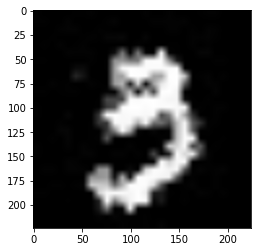

In [9]:
img, c = pipeline.run()
img = img.as_cpu()
print(int(bytes(c.as_array()[2]))) # Conversion from an array of bytes back to bytes and then to int
plt.imshow(img.as_array()[2])
plt.show()

## Checking consistency
We can then compare our pipeline with a one that uses a predefined reader

First let's define the pipeline to compare against

In [10]:
@dali.pipeline_def(batch_size=16, num_threads=4, device_id=0)
def file_pipeline(files):
    img, _ = fn.readers.file(files=files)
    return decode_augment(img)

Then let's instantiate and build both pipelines

In [11]:
webdataset_pipeline_instance = webdataset_pipeline(tar_dataset_paths, random_shuffle=True, initial_fill=1)
webdataset_pipeline_instance.build()
file_pipeline_instance = file_pipeline(folder_dataset_files)
file_pipeline_instance.build()

And run the comparison loop

In [12]:
for _ in range(1000):
    webdataset_pipeline_threw_exception = False
    file_pipeline_threw_exception = False
    
    try:
        web_img, _ = webdataset_pipeline_instance.run()
    except StopIteration:
        webdataset_pipeline_threw_exception = True
    
    try:
        (file_img,) = file_pipeline_instance.run()
    except StopIteration:
        file_pipeline_threw_exception = True
    
    # In case of different number of batches
    if webdataset_pipeline_threw_exception != file_pipeline_threw_exception:
        print("Found a difference between the readers!")
        break

    web_img = web_img.as_cpu().as_array()
    file_img = file_img.as_cpu().as_array()

    if (web_img != file_img).any():
        print("Found a difference between the readers!")
        break
else:
    print("No difference found!")

No difference found!
